# Project 4: Hackathon

## *Data Cleaning and EDA*

In this notebook:

* [Problem Statement](#problem)
* [Data Cleaning](#cleaning)
* [Formatting for Classification](#format)
* [EDA](#EDA)

## Problem Statement <a class="anchor" id="problem"></a>
<hr/>
I found a data set on Kaggle which contains around 10,000 songs from 25 different genres from Spotify. My goal is to find a model that can predict a song's popularity given the audio features provided by Spotify. Maybe create a new category and reduce it down to a binary classification problem rating as just 'popular' vs 'not popular' for songs above or below the mean popularity score.


### The Data
Data set obtained from: https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

Spotify audio features explained here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

## Import Libraries & Read in Data
<hr/>

In [2]:
## standard imports 
import pandas as pd 
import numpy as np
import re
## visualizations
import matplotlib.pyplot as plt
import seaborn as sns
## preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyClassifier
## modeling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
## trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor
## NLP
from sklearn.feature_extraction.text import CountVectorizer
## analysis
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer, f1_score, mean_squared_error

## options
import sklearn
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 100
pd.set_option('max_colwidth', 100)

In [34]:
### read in data
data = pd.read_csv('../data/SpotifyFeatures.csv', encoding='utf-8')

In [35]:
data.head()

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737             0.000  F#    0.1510    -5.559  Minor   
2       170267   0.131             0.000   C    0.1030   -13.879  Minor   
3       152427   0.326             0.000  C#    0.0985   -12.178  Major   
4        82625   0.225             0.123   F    0.2020   -21.150  Major   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368  
3       0.0395  171.758            4/4    0.227  
4       0.0456  140.576            4/4    0.390

## Data Cleaning <a class="anchor" id="cleaning"></a>
<hr/>

In [36]:
data.columns

Index(['genre', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')

Don't need all of these columns. Only going to keep the audio features with numerical data. I decided to drop `duration_ms` as well just to simplify things a bit more.

In [37]:
### drop unnecessary columns
data.drop(columns=['time_signature', 'mode', 'key', 'artist_name', 'track_name', 'duration_ms'], inplace=True)

In [38]:
data.head()

genre                track_id  popularity  acousticness  danceability  \
0  Movie  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  Movie  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  Movie  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  Movie  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  Movie  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   energy  instrumentalness  liveness  loudness  speechiness    tempo  valence  
0   0.910             0.000    0.3460    -1.828       0.0525  166.969    0.814  
1   0.737             0.000    0.1510    -5.559       0.0868  174.003    0.816  
2   0.131             0.000    0.1030   -13.879       0.0362   99.488    0.368  
3   0.326             0.000    0.0985   -12.178       0.0395  171.758    0.227  
4   0.225             0.123    0.2020   -21.150       0.0456  140.576    0.390

In [45]:
### check for NA values
data.isna().sum()

genre               0
track_id            0
popularity          0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

### Clean up `genres`

In [39]:
data['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: genre, dtype: int64

Looks like there are two different characters for quotations in Children's Music. To keep classes balanced we're going to drop the ones listed later in the list and then convert the ones using the curly apostrophe to using the proper version of the apostrophe.

We're also going to just drop A Capella since this is such a small class.

In [40]:
data.drop(data[data['genre'] == 'Children\'s Music'].index, inplace=True)

In [41]:
### replace curly apostrophe with usual one. Didn't know which one it was so using regex to search all of them
data['genre'] = data['genre'].replace('[\u0027\u02B9\u02BB\u02BC\u02BE\u02C8\u02EE\u0301\u0313\u0315\u055A\u05F3\u07F4\u07F5\u1FBF\u2018\u2019\u2032\uA78C\uFF07]+', '\'', regex=True)

In [42]:
### drop A Capella
data.drop(data[data['genre'] == 'A Capella'].index, inplace=True)

In [43]:
data['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children's Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Name: genre, dtype: int64

In [ ]:
### Export cleaned data set
data.to_csv('../data/data_cleaned.csv', encoding='utf-8', index=False)

## Formatting Data for Classification Models <a class="anchor" id="format"></a>
<hr/>

We're going to add a binary classification feature.

First, we wrote a function to easily create subsets of data based on genre to test models.

In [81]:
### Create genre specific data for testing
def create_genre_classification(df, genre, make_csv=False):
    '''creates genre specific subset of data for small scale testing of models'''
    genre_df = df[df['genre'] == genre].copy()
    ### create is_popular category
    genre_df['is_popular'] = np.where(genre_df['popularity'] >= genre_df['popularity'].median(), 1, 0)
    genre_df.drop(columns=['popularity'], inplace=True)
    
    csv_name = re.sub('([\-\&\'\s])+','', genre).lower()
    
    if make_csv:
        genre_df.to_csv(f'../data/{csv_name}.csv', index=False)
    return genre_df

In [79]:
### testing formatting of csv name in function
# test_genres = ['Hip-Hop', 'R&B', 'Children\'s Music']

# for genre in test_genres:
#     csv_name = re.sub('([\-\&\'\s])+','', genre).lower()
#     print(csv_name)

In [83]:
### Create 3 test sets
genres = ['Rock', 'Hip-Hop', 'Country']

for genre in genres:
    create_genre_classification(data, genre, make_csv=True)

### Add column to larger data set

In [85]:
data['is_popular'] = np.where(data['popularity'] >= data['popularity'].median(), 1, 0)

In [86]:
data.head()

genre                track_id  popularity  acousticness  danceability  \
0  Movie  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  Movie  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  Movie  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  Movie  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  Movie  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   energy  instrumentalness  liveness  loudness  speechiness    tempo  \
0   0.910             0.000    0.3460    -1.828       0.0525  166.969   
1   0.737             0.000    0.1510    -5.559       0.0868  174.003   
2   0.131             0.000    0.1030   -13.879       0.0362   99.488   
3   0.326             0.000    0.0985   -12.178       0.0395  171.758   
4   0.225             0.123    0.2020   -21.150       0.0456  140.576   

   valence  is_popular  
0    0.814           0  
1    0.816           0  
2    0.368           0  
3    0.227           0  
4    0.390           0

In [87]:
### Export cleaned data set
data.to_csv('../data/data_cleaned_classification.csv', encoding='utf-8', index=False)

In [88]:
data['is_popular'].value_counts()

1    114071
0    113132
Name: is_popular, dtype: int64

## EDA <a class="anchor" id="EDA"></a>
<hr/>

### Examine Full Data Set

Text(0.5, 1.0, 'Popularity')

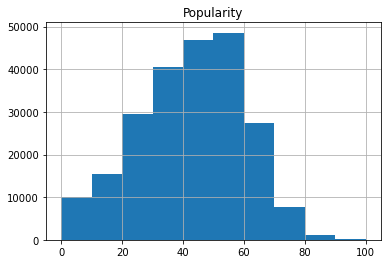

In [59]:
data['popularity'].hist()
plt.title('Popularity')

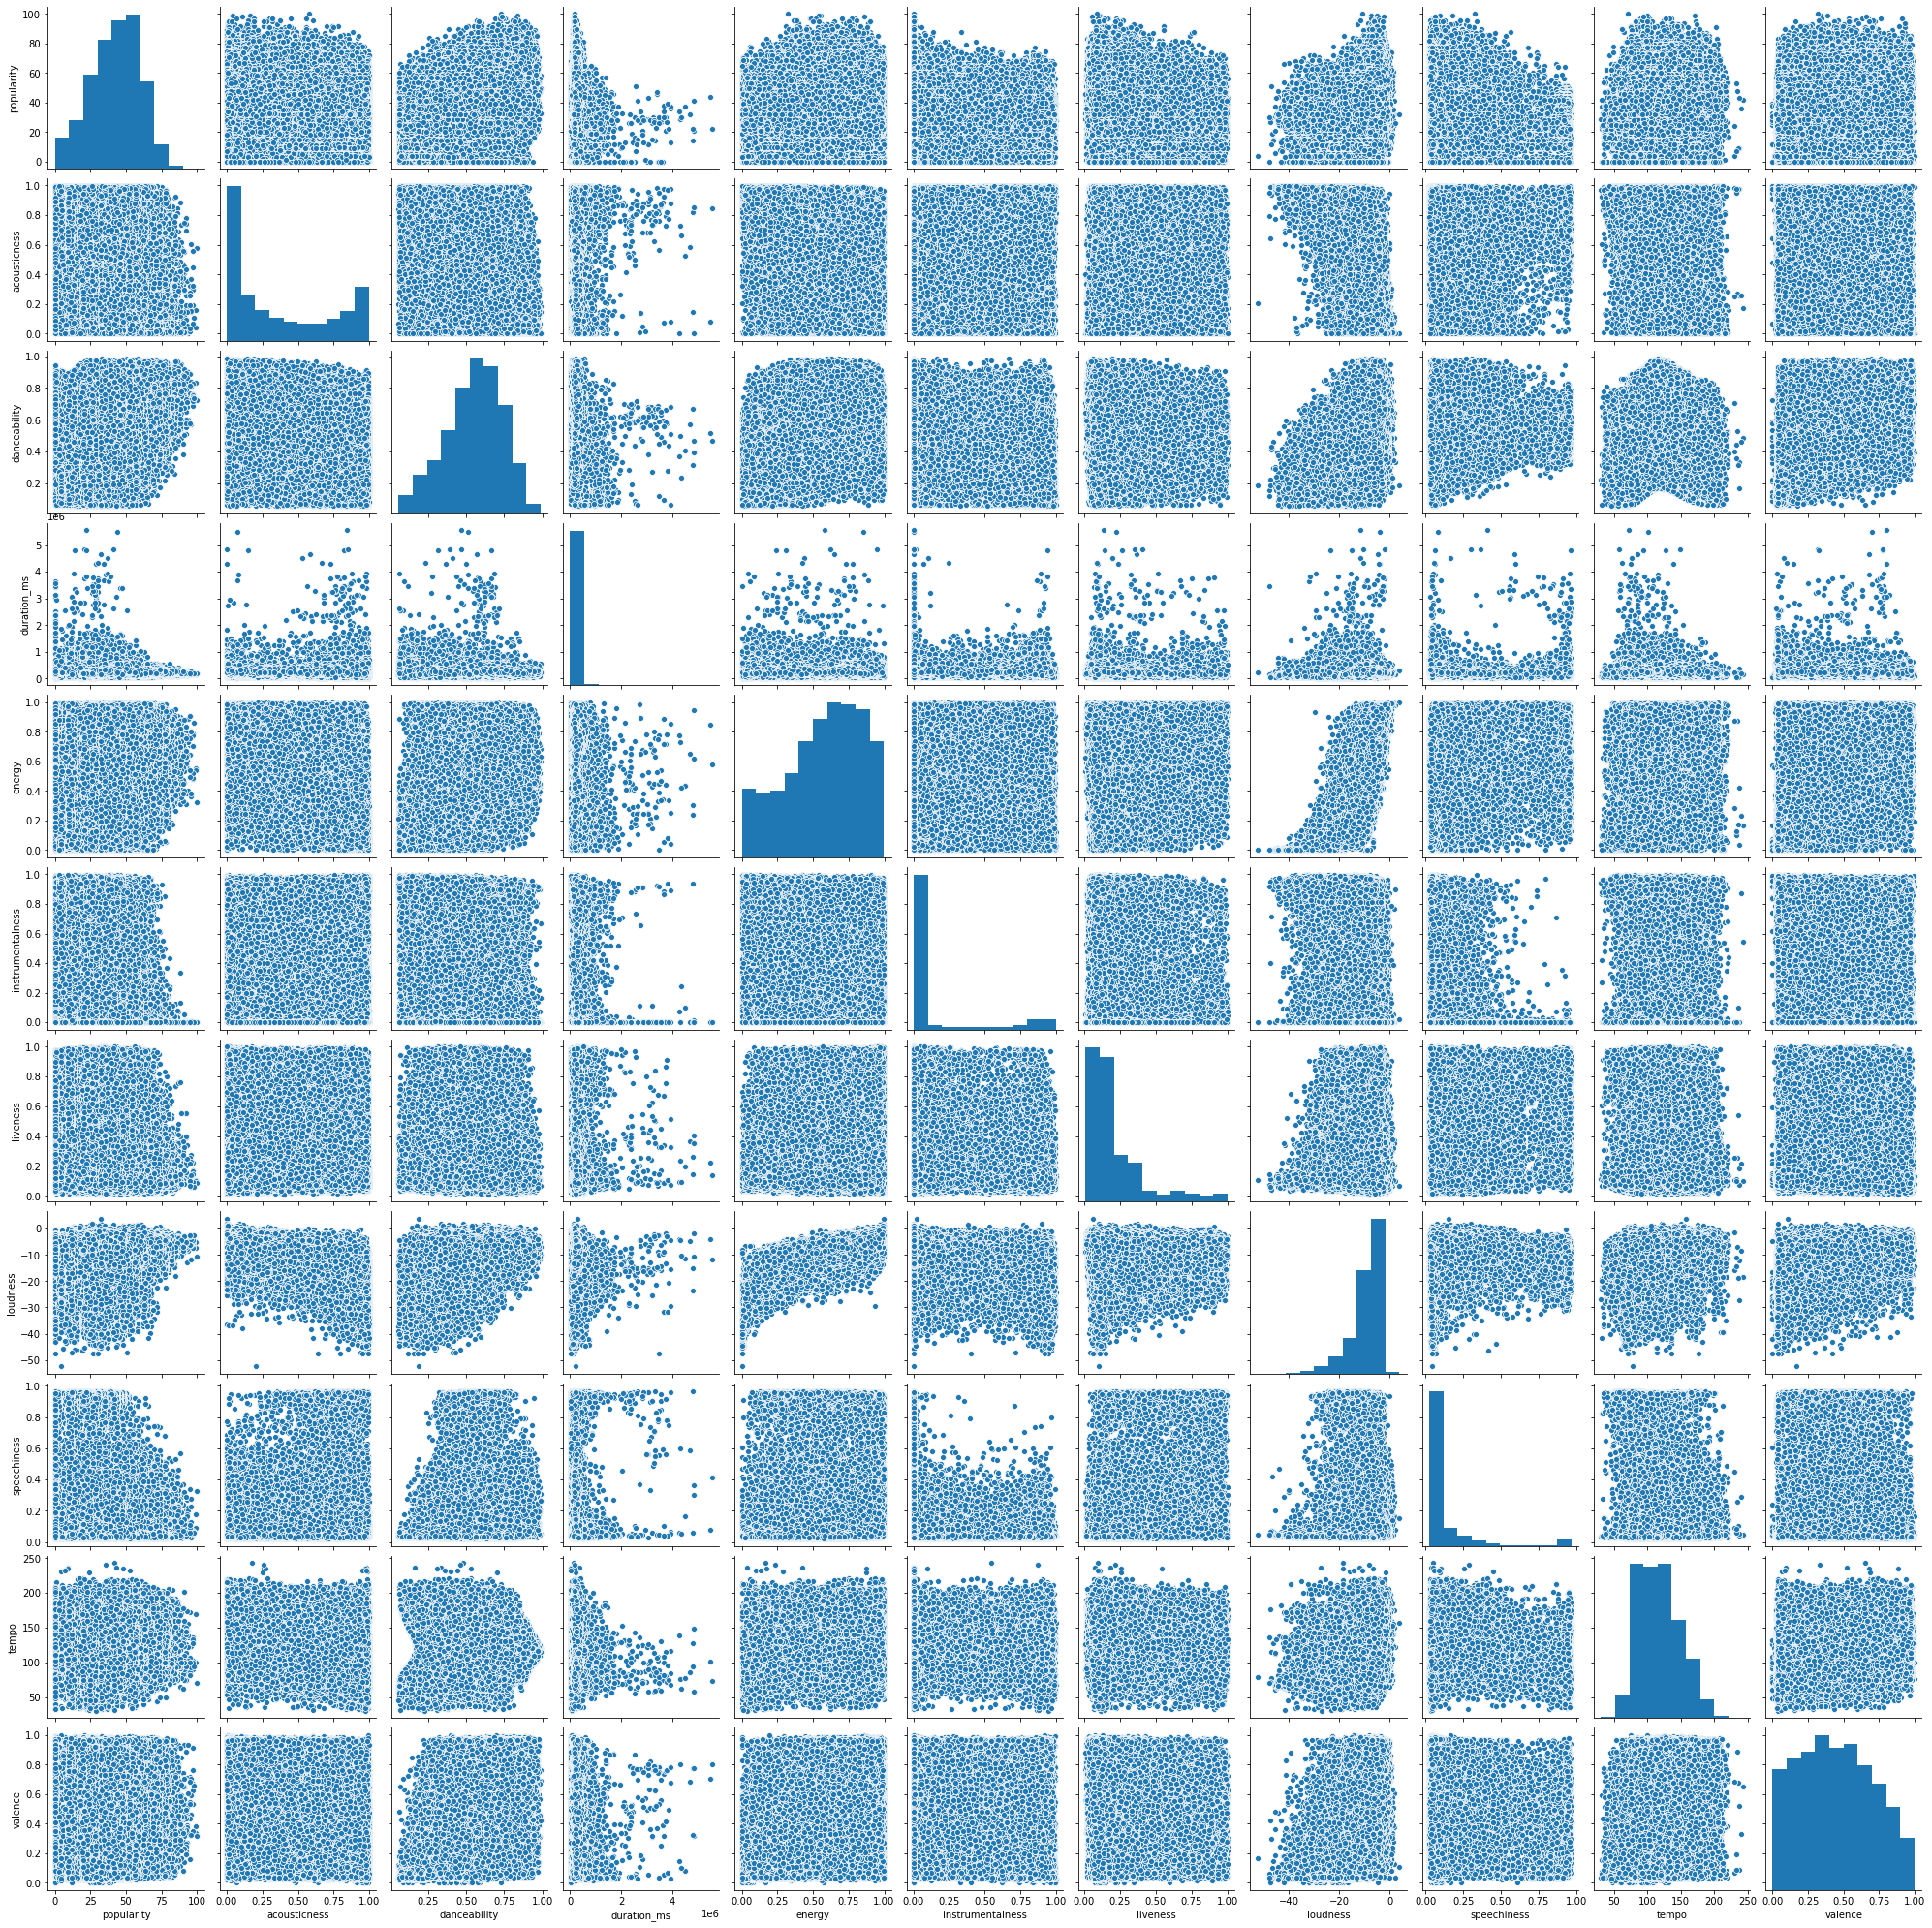

In [62]:
sns.pairplot(data)

let's reduce it to a single genre to see if there is anything of interest there

### Examine a single genre: Hip-Hop

In [4]:
### read in data
hiphop = pd.read_csv('../data/hiphop.csv', encoding='utf-8')

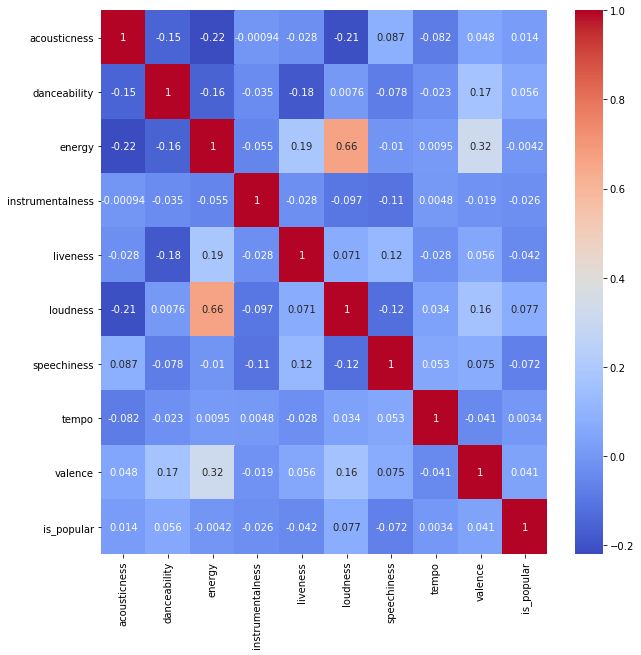

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(hiphop.corr(), annot=True, cmap='coolwarm')

Looks like `loudness` and `energy` have the highest correlation here. Makes sense I guess.


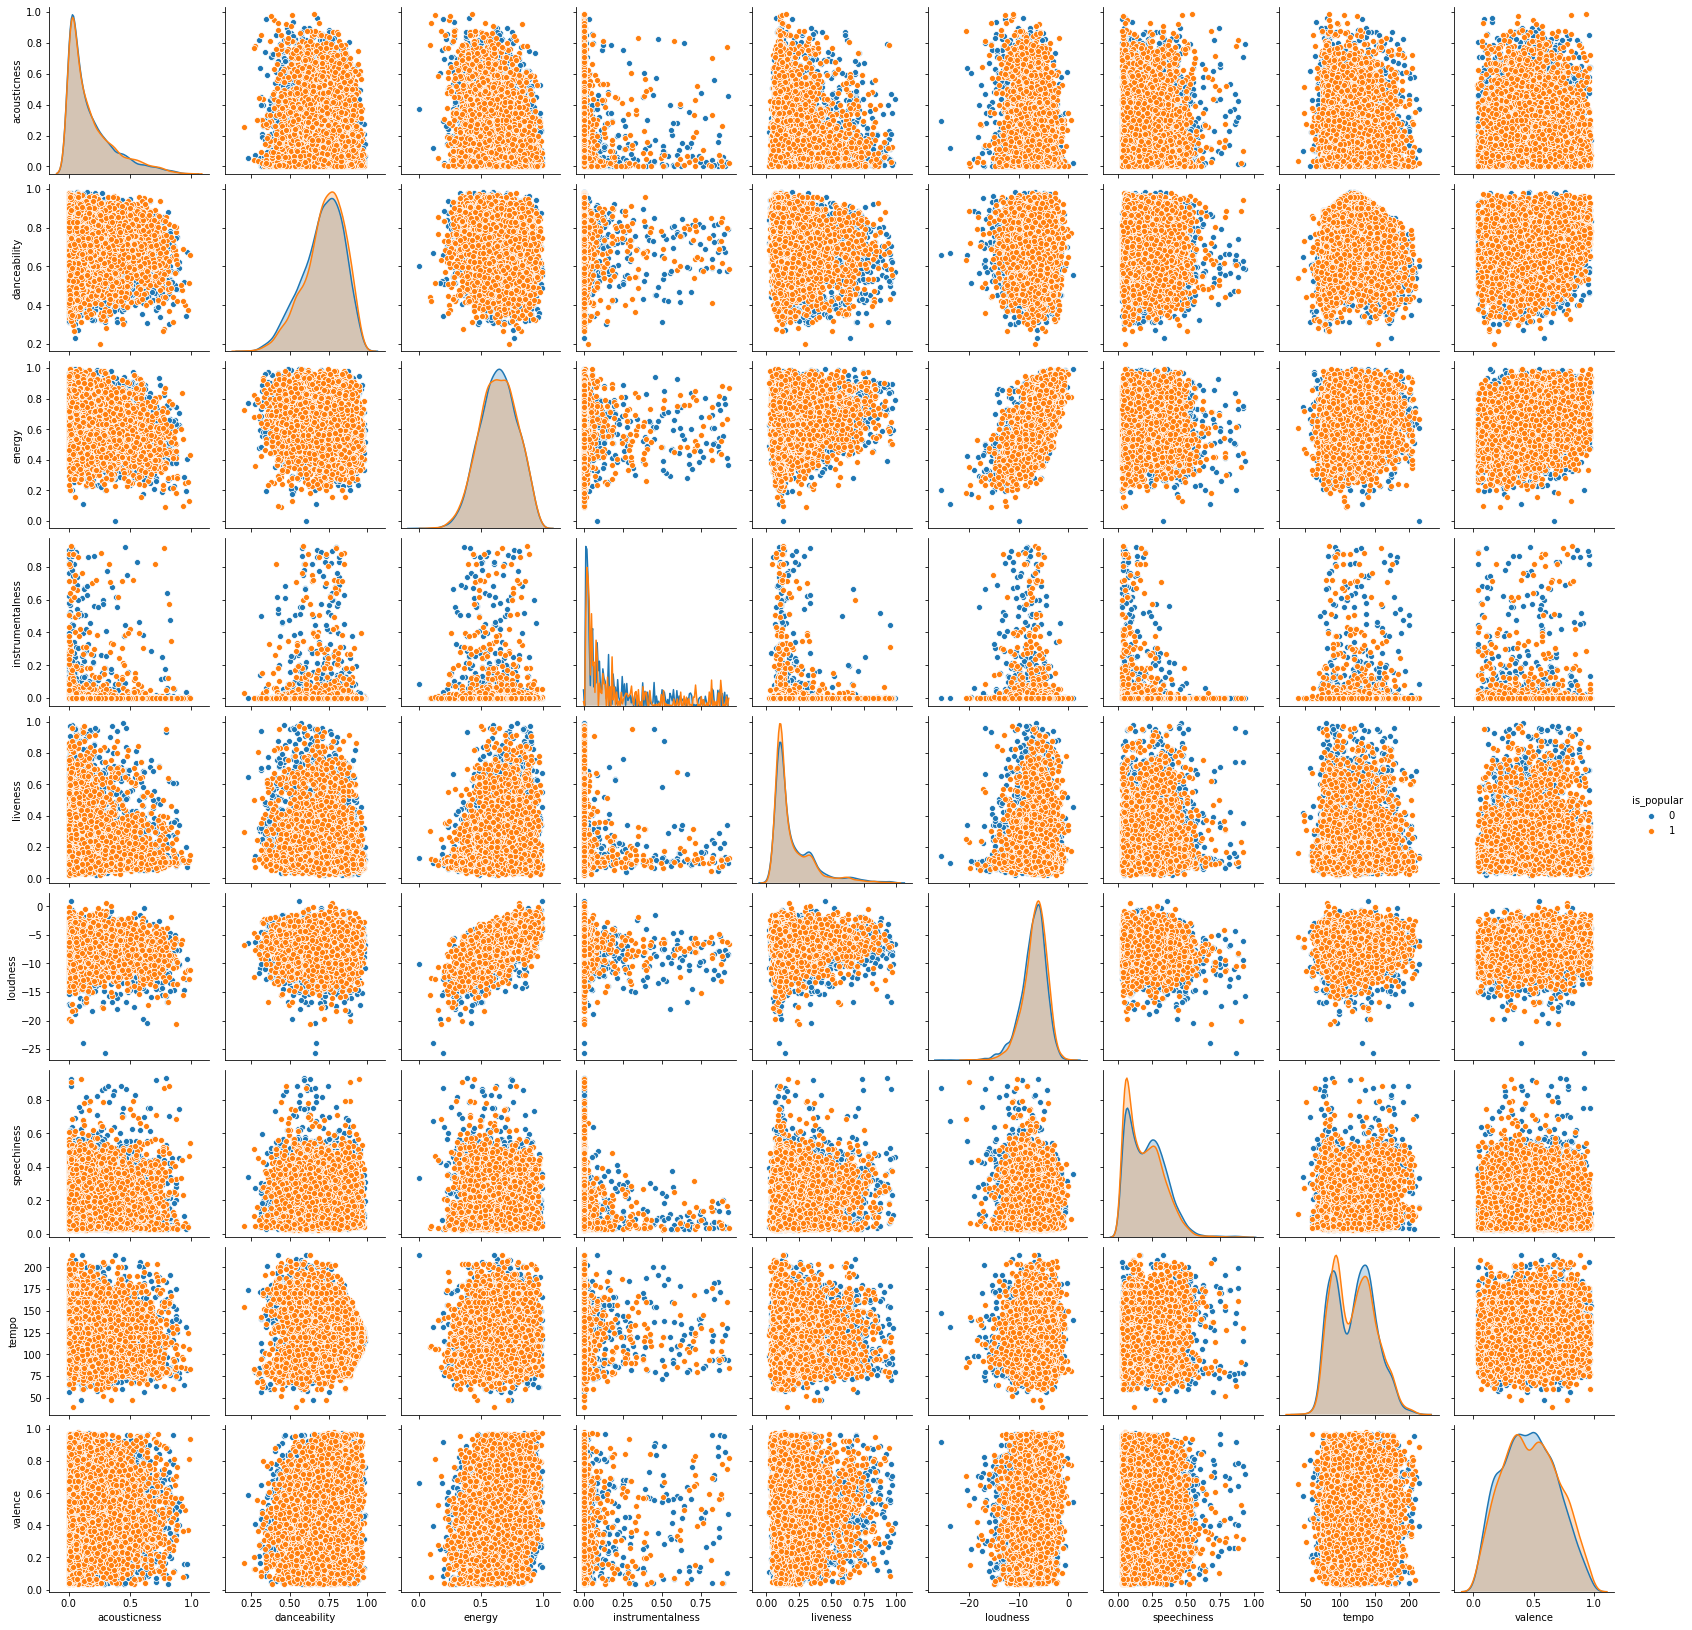

In [8]:
sns.pairplot(hiphop, hue='is_popular')

Text(0.5, 1.0, 'Danceability vs Energy')

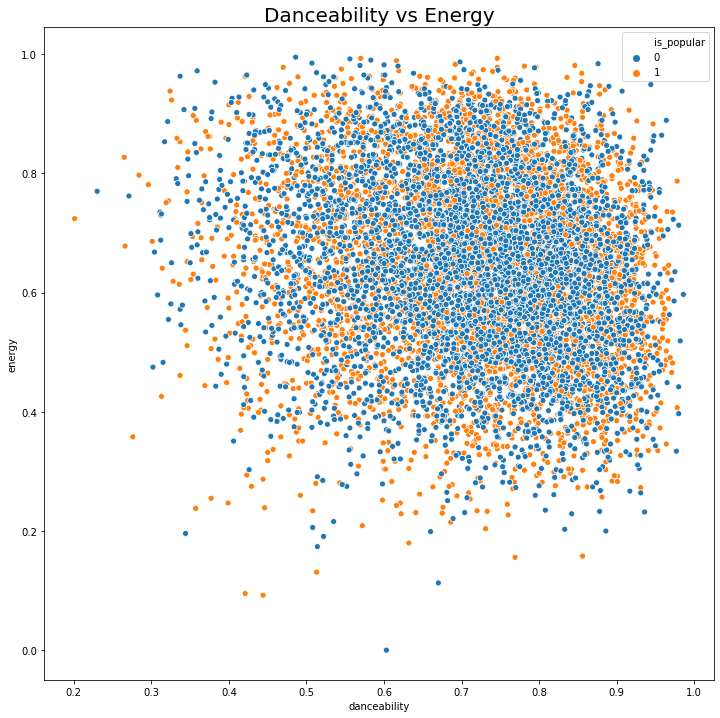

In [9]:
plt.figure(figsize=(12,12))

sns.scatterplot(
    data=hiphop, 
    x='danceability', 
    y='energy', 
    hue='is_popular', 
#     size='color_intensity',
    palette='tab10',
    # alpha=.5
    # maybe give each cluster a different marker type 
)
plt.title('Danceability vs Energy', fontdict={'fontsize':20})

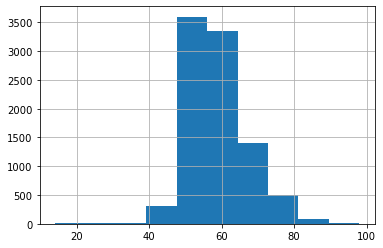

In [23]:
hiphop['popularity'].hist()

### Creating Datasets with Popularity for analysis

In [3]:
df = pd.read_csv('../data/data_cleaned_classification.csv')

In [7]:
df['genre'].value_counts()

Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children's Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9096
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Name: genre, dtype: int64

In [5]:
### Create genre specific data for testing
def create_full_genre_dataset(df, genre, make_csv=False):
    '''creates genre specific subset of data for small scale testing of models'''
    genre_df = df[df['genre'] == genre].copy()
    ### create is_popular category
    genre_df['is_popular'] = np.where(genre_df['popularity'] >= genre_df['popularity'].median(), 1, 0)
#     genre_df.drop(columns=['popularity'], inplace=True)
    
    csv_name = re.sub('([\-\&\'\s])+','', genre).lower()
    
    if make_csv:
        genre_df.to_csv(f'../data/{csv_name}_full.csv', index=False)
    return genre_df

In [8]:
create_full_genre_dataset(df, 'Hip-Hop', make_csv=True)

genre                track_id  popularity  acousticness  \
66488  Hip-Hop  2JvzF1RMd7lE3KmFlsyZD8          96       0.14900   
66489  Hip-Hop  2IRZnDFmlqMuOrYOLnZZyc          95       0.25900   
66490  Hip-Hop  2t8yVaLvJ0RenpXUIAC52d          93       0.03950   
66491  Hip-Hop  79OEIr4J4FHV0O3KrhaXRb          88       0.00195   
66492  Hip-Hop  1xzBco0xcoJEDXktl7Jxrr          92       0.19400   
...        ...                     ...         ...           ...   
87297  Hip-Hop  3tFKwypoyJXWxAq9FCJ8Lz          45       0.27700   
87298  Hip-Hop  7y0T0GrkJOUZm1iXwCxJqQ          48       0.01620   
87299  Hip-Hop  7oeWitA7Lu8O76NrmhfgZ8          45       0.06850   
87300  Hip-Hop  3VQkY3tvpMxE7E7XuGNmoD          51       0.41700   
87301  Hip-Hop  0UmIdWRGDL5gkXnqG9ZozM          46       0.03630   

       danceability  energy  instrumentalness  liveness  loudness  \
66488         0.837   0.364           0.00000    0.2710   -11.713   
66489         0.889   0.496           0.00000    0.2520    -6.365   
66490         0.837   0.636           0.00125    0.3420    -7.643   
66491         0.942   0.383           0.00000    0.0922    -8.099   
66492         0.729   0.625           0.00986    0.2480    -5.266   
...             ...     ...               ...       ...       ...   
87297         0.617   0.576           0.00000    0.0883    -4.773   
87298         0.542   0.792           0.00000    0.2390    -3.525   
87299         0.419   0.713           0.54100    0.2910    -8.867   
87300         0.847   0.289           0.00501    0.1210    -9.833   
87301         0.855   0.874           0.02160    0.0869    -4.018   

       speechiness    tempo  valence  is_popular  
66488       0.2760  123.984   0.4630           1  
66489       0.0905   86.003   0.5440           1  
66490       0.0860  145.972   0.2740           1  
66491       0.5650  100.021   0.3800           1  
66492       0.0315  146.034   0.2610           1  
...            ...      ...      ...         ...  
87297       0.0982   97.899   0.0423           0  
87298       0.3070  142.247   0.3710           0  
87299       0.0976  186.785   0.5550           0  
87300       0.0617  104.248   0.0659           0  
87301       0.2100   89.449   0.8610           0  

[9295 rows x 13 columns]